# Master Pipelines with hetrogenous data: text and numeric features

`By   : Dr. James G. Shanahan`

`EMAIL: James.Shanahan AT Gmail.com`

## Goals of this notebook:

* Learn how use pipelines with text and numeric features
*  Understand logloss and how to explain experimental values of logloss
* Hone your pipelining skills on hetrogeneous input features
* Mixing hetrogenous features: combining text-based features and numeric features in a single pipeline
* How to process text data in the 3-class classification problem 
* Hierarchical pipelines and hyperparameter optimization
  * Hyperparameter optimization when you have pipelines of pipelines of pipelines of pipelines etc... 




## Casestudy: Spooky author identification (SAI)


The casestudy is based on the   Kaggle Competition [Spooky Author Identification (SAI)](https://www.kaggle.com/c/spooky-author-identification). The competition finished in December 2017. Ntl, it is a great dataset to hone your pipelining skills on hetrogeneous input features.

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. **Your objective is to accurately identify the author of the sentences in the test set.**


## Some of the challenges

1. Dataset size is small
   * (7 meg uncompressed) 
* Dealing with text data



# Pipelines, Transformers versus Estimators versus ColumnTransformer

Most machine learning applications require not only the application of a single algorithm,
but the chaining (composing) together of many different processing steps and machine learning
models. The  Pipeline class simplifies the
process of building chains of transformations and models. Pipelines can be combined with GridSearchCV to search over parameters for all
processing steps at once. 

Definition of pipeline class according to scikit-learn is

* `Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit.`

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code. Pipelines allow for experiments, and for a dataset like this that only has the text as a feature, you're going to need to do a lot of experiments. Plus, when your modeling gets really complicated, it's sometimes hard to see if you have any data leakage hiding somewhere. Pipelines are set up with the fit/transform/predict functionality, so you can fit a whole pipeline to the training data and transform to the test data, without having to do it individually for each thing you do. 

This notebook is going to break down the pipeline process to make it easier to see how they all fit together. While not exhaustive, it should get you started on building your own pipelines so you can spend more time on the good stuff, thinking.

### A short chapter as a reference 
A short book chapter from `Introduction_to_Machine_Learning_with_Python` by by Andreas C. Müller (Author), Sarah Guido (O'Reilly, 2016) is included in this directory for more background on SKLearn Pipelines.

## Transformers versus Estimators
SKLearn standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. This notebook covers the key concepts introduced by the SKLearn API.

## numpy arrays versus pandas dataframes
Arrays/DataFrame: SKLearn uses numpy arrays to store ML datasets. In special cases (in pipeline mode) DataFrame can also be used as ML datasets, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.

## Transformer: 
A Transformer is an algorithm which can transform one dataset into another (usually resulting in a numpy array). 

## Estimator: 
An Estimator is an algorithm which can be fit on a dataset to produce a model. 

## Pipeline: 
A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.


## ColumnTransformer as a special transformer for heterogeneous data
Many datasets contain features of different types, say text, floats, and dates, where each type of feature requires separate preprocessing or feature extraction steps. Often it is easiest to preprocess data before applying scikit-learn methods, for example using pandas. Processing your data before passing it to scikit-learn might be problematic for one of the following reasons:
Incorporating statistics from test data into the preprocessors makes cross-validation scores unreliable (known as data leakage), for example in the case of scalers or imputing missing values.
You may want to include the parameters of the preprocessors in a parameter search.
The ColumnTransformer helps performing different transformations for different columns of the data, within a Pipelinethat is safe from data leakage and that can be parametrized. ColumnTransformer works on arrays, sparse matrices, andpandas DataFrames.

Useful links: 
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html 
https://scikit-learn.org/stable/modules/compose.html#featureunion-composite-feature-spaces![image.png](attachment:image.png)

# Kaggle API setup
Kaggle is a Data Science Competition Platform which shares a lot of datasets. In the past, it was troublesome to submit your result as your have to go through the console in your browser and drag your files there. Now you can interact with Kaggle via the command line. E.g., 

```bash
! kaggle competitions files home-credit-default-risk
```

It is quite easy to setup, it takes me less than 15 minutes to finish a submission.

1. Install library
* Create a API Token (edit your profile on [Kaggle.com](https://www.kaggle.com/)); this produces `kaggle.json` file
* Put your JSON `kaggle.json` in the right place
* Access competition files; make submissions via the command (see examples below)
* Submit result

For more detailed information on setting the Kaggle API see [here](https://medium.com/@nokkk/make-your-kaggle-submissions-with-kaggle-official-api-f49093c04f8a) and [here](https://github.com/Kaggle/kaggle-api).



In [1]:
!pip install kaggle

In [2]:
!pwd


/root/shared/Dropbox/Projects/Courses/DataScienceAtScale/Src/I526_AML_Dev_CADG/Labs/Labs-09-Pipelines-Text-spooky-author-identification


In [23]:
!mkdir ~/.kaggle
!cp /root/shared/Downloads/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/root/shared/Downloads/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! kaggle competitions files spooky-author-identification

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# Dataset and how to download


## Background 

The course project is based on the [Spooky Author Identification (SAI)  Kaggle Competition](https://www.kaggle.com/c/spooky-author-identification). The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. **Your objective is to accurately identify the author of the sentences in the test set.**



## SAI File descriptions
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

## SAI Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

A reminder: this is a Kaggle playground competition: On Kaggle, the spirit of playground competitions is to have fun and learn together. Your score on the leaderboard doesn't earn you points, but you can still make it a rewarding competition for everyone by sharing your code in Kernels and contributing to Discussions. In short, please don't look up the answers.


## Downloading the files via Kaggle API

Create a base directory:

```bash
DATA_DIR = "../../../Data/spooky-author-identification"   #same level as course repo in the data directory
```

Please download the project data files and data dictionary and unzip them using either of the following approaches:

1. Click on the `Download` button on the following [Data Webpage](https://www.kaggle.com/c/spooky-author-identification/data) and unzip the  zip file to the `BASE_DIR`
2. If you plan to use the Kaggle API, please use the following steps.


In [24]:
competition = "spooky-author-identification"
DATA_DIR = f"../../../Data/{competition}"   #same level as course repo in the data directory
#DATA_DIR = os.path.join('./ddddd/')
!mkdir $DATA_DIR

mkdir: cannot create directory ‘../../../Data/spooky-author-identification’: File exists


In [25]:
!ls -l $DATA_DIR

total 6932
-rw-r--r-- 1 root root  537111 Oct 25  2017 sample_submission.csv
-rwxr-xr-x 1 root root   30082 Jun 19  2018 sample_submission.zip
-rw-r--r-- 1 root root 1351241 Oct 25  2017 test.csv
-rwxr-xr-x 1 root root  551200 Jun 19  2018 test.zip
-rw-r--r-- 1 root root 3295644 Oct 25  2017 train.csv
-rwxr-xr-x 1 root root 1319237 Jun 19  2018 train.zip


In [7]:
#! kaggle competitions download home-credit-default-risk -p $DATA_DIR

### Imports

In [26]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [27]:
unzippingReq = False
if unzippingReq: #please modify this code 
    zip_ref = zipfile.ZipFile('application_train.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('application_test.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('bureau_balance.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('bureau.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('credit_card_balance.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('installments_payments.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('POS_CASH_balance.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()
    zip_ref = zipfile.ZipFile('previous_application.csv.zip', 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

## Data files overview


### SAI Train Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)



### Train data

In [28]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

target = 'author'
datasets={}  # lets store the datasets in a dictionary so we can keep track of them easily
ds_name = 'train'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)
#df.dropna(axis=0)
#datasets[ds_name].set_index('id', inplace = True)
#datasets[ds_name].head()

train: shape is (19579, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB
None


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [29]:
ds_name = 'test'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)
#df.dropna(axis=0)

test: shape is (8392, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
id      8392 non-null object
text    8392 non-null object
dtypes: object(2)
memory usage: 131.2+ KB
None


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [30]:
datasets.keys()

dict_keys(['train', 'test'])

In [31]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')


dataset train                   : [     19,579, 3]
dataset test                    : [      8,392, 2]


# Exploratory Data Analysis

## Summary of  train data

In [32]:
datasets["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


In [33]:
datasets["train"].describe() #numerical only features

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id12140,And so it was with the waking nightmare of Tem...,EAP
freq,1,1,7900


In [34]:
datasets["test"].describe() #numerical only features

,id,text
count,8392,8392
unique,8392,8392
top,id05609,"Deep in midnight, she was awaked by a rustling..."
freq,1,1


In [35]:
datasets["train"].describe(include='all') #look at all categorical and numerical

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id12140,And so it was with the waking nightmare of Tem...,EAP
freq,1,1,7900


## Missing data for application train

In [36]:
percent = (datasets["train"].isnull().sum()/datasets["train"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["train"].isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
author,0.0,0
text,0.0,0
id,0.0,0


In [37]:
percent = (datasets["test"].isnull().sum()/datasets["test"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["test"].isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Test Missing Count"])
missing_application_train_data.head(20)

,Percent,Test Missing Count
text,0.0,0
id,0.0,0


## Distribution of the target column 

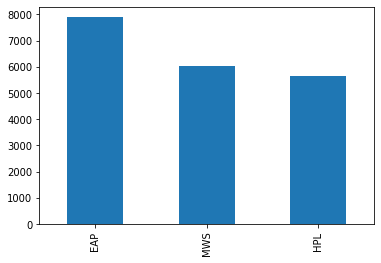

In [38]:
datasets["train"]['author'].value_counts().plot(kind='bar')

In [40]:
datasets["test"]


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...
...,...,...
8387,id11749,All this is now the fitter for my purpose.
8388,id10526,I fixed myself on a wide solitude.
8389,id13477,It is easily understood that what might improv...
8390,id13761,"Be this as it may, I now began to feel the ins..."


In [47]:
#unnecessary step. Skip if it crashes
# TODO fix this step
datasets["test"]['author'].value_counts().plot(kind='bar')  # What? Why? (Hint: Kaggle competition)

KeyError: 'author'

## Analysing the text feature and some feature engineering

To begin, let's do some analysis of the text feature and possibly use these as features later during modeling (the machine learning) phase. In anticipation of that and to  make it easier to replicate within a pipeline (and subsequently apply the same workflow to, say, a test set or a Kaggle submission file), we will encapsulate the logic into a function for now (and rewrite it as a transformer class later so we can incorporate it into a modeling and prediction pipeline).

Note, all of this preprocessing is standard stuff, and does not depend on the data it's processing on, so it's ok to do this now. For now, we will analyse the text feature as follows:

* count the number of words in each row 
* the number of characters
* the number of non stop words 
* punctuation to text characters ratio 

### Regular expression operations (detour)
The Regular Expression module in Python provides regular expression matching operations similar to those found in Perl.

Both patterns and strings to be searched can be Unicode strings as well as 8-bit strings. However, Unicode strings and 8-bit strings cannot be mixed: that is, you cannot match an Unicode string with a byte pattern or vice-versa; similarly, when asking for a substitution, the replacement string must be of the same type as both the pattern and the search string.

Regular expressions use the backslash character (`'\'`) to indicate special forms or to allow special characters to be used without invoking their special meaning. This collides with Python’s usage of the same character for the same purpose in string literals; for example, to match a literal backslash, one might have to write `'\\\\'` as the pattern string, because the regular expression must be `\\`, and each backslash must be expressed as `\\` inside a regular Python string literal.

#### string literal prefixed with `'r'`
The solution is to use Python’s raw string notation for regular expression patterns; backslashes are not handled in any special way in a string literal prefixed with `'r'`. So `r"\n"` is a two-character string containing `'\'` and `'n'`, while `"\n"` is a one-character string containing a newline. Usually patterns will be expressed in Python code using this raw string notation.

It is important to note that most regular expression operations are available as module-level functions and methods on compiled regular expressions. The functions are shortcuts that don’t require you to compile a regex object first, but miss some fine-tuning parameters.For more information on parsing and regular expressions in Python see [here]
(https://docs.python.org/3.2/library/re.html)

E.g., replace each `non-word and non-space` character with a space (so we can split the string into tokens/words later using `split()`. 

```python
# replace each "non-word and non-space" characters with a space
# #\w [a-zA-Z0-9_] \s [ \t\n\r\f\v]
>>>re.sub(r'[^\w\s]',' ', "abac? a,b,c d; a!")

'abac  a b c d  a '
```



In [41]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
import string
import re
string.punctuation

# replace each "non-word and non-space" characters with a space
# #\w [a-zA-Z0-9_] \s [ \t\n\r\f\v]
text = 'abac? a,b,c d; a! a,'
regExpr = r'[^\w\s]'
print(f"regExpr: {regExpr}")
print(f"before:  [{text}]")
print(f"after:   [{re.sub(regExpr,' ', text)}]")
print("-------------------------------------------------")
print(f"text.count(','):   [{text.count('a,')}]")
print(f"sum(map(text.count, [',','.', '?']))):   [{sum(map(text.count, ['l','o']))}]")
print(f"string.punctuation :   [{string.punctuation}]")
print(f"sum(map(text.count, string.punctuation)):   {sum(map(text.count, string.punctuation))} punctuation chars")
print(f"punctuation ratio:   {sum(map(text.count, string.punctuation))/len(text)} punctuation chars")


regExpr: [^\w\s]
before:  [abac? a,b,c d; a! a,]
after:   [abac  a b c d  a  a ]
-------------------------------------------------
text.count(','):   [2]
sum(map(text.count, [',','.', '?']))):   [0]
string.punctuation :   [!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
sum(map(text.count, string.punctuation)):   6 punctuation chars
punctuation ratio:   0.3 punctuation chars


In [44]:
import string
string.punctuation
text = 'abac? a,b,c d; a! a,'

sum(map(text.count, string.punctuation))

6

In [48]:
datasets["train"].head().values
#datasets.keys()

array([['id26305',
        'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.',
        'EAP',
        'this process  however  afforded me no means of ascertaining the dimensions of my dungeon  as i might make its circuit  and return to the point whence i set out  without being aware of the fact  so perfectly uniform seemed the wall ',
        231, 48, 28, 4.785714285714286, 0.030303030303030304, 4],
       ['id17569',
        'It never once occurred to me that the fumbling might be a mere mistake.',
        'HPL',
        'it never once occurred to me that the fumbling might be a mere mistake ',
        71, 15, 7, 5.285714285714286, 0.014084507042253521, 0],
       ['id11008',
        'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he 

In [49]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stopWords = set(stopwords.words('english'))

# creating a function to encapsulate EDA/preprocessing
# Take a dataframe as input and return DF as output
# Add new numerical features to the dataframe (e.g., number of words in the string)
#
def textPreprocessing(df):
    #lowercase the text strings and remove punctuation
    # store in a new column
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))  #\w [a-zA-Z0-9_] \s [ \t\n\r\f\v]
    
    # numerical feature engineering
    # total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    # get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    # get the average word length
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    # get the sum(map(text.count, string.punctuation))/len(text)
    df['punctuationRatio'] = df['text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    return(df)  # return a dataframe for now

datasets["train"] = textPreprocessing(datasets["train"])
datasets["train"].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text,author,processed,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of...,231,48,28,4.785714,0.030303,4
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,15,7,5.285714,0.014085,0
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from wh...,200,41,24,4.708333,0.025000,4
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,38,25,5.440000,0.019417,3
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the super...,174,31,20,5.750000,0.022989,2


## Correlation with  the target variable(s)

* Convert the categorical target variable into [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)),  
* Concatenate the dummy target variables  in a numpy.array,
* Drop text features
* and compute the correlation. 

In [50]:
#Convert categorical variable color_head into dummy variables:
df = datasets["train"]
df_dummies = pd.get_dummies(df[target])
df_dummies.head()

,EAP,HPL,MWS
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1
4,0,1,0


In [51]:
df.head()

,id,text,author,processed,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of...,231,48,28,4.785714,0.030303,4
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,71,15,7,5.285714,0.014085,0
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from wh...,200,41,24,4.708333,0.025000,4
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,206,38,25,5.440000,0.019417,3
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the super...,174,31,20,5.750000,0.022989,2


In [52]:
df = pd.concat([df, df_dummies], axis=1)
df = df.drop([target, 'id', 'text', 'processed'], axis=1)
correlation_matrix = np.corrcoef((df.values).T) #Put df in numpy array
(correlation_matrix)



array([[ 1.        ,  0.98719521,  0.96270534,  0.23334319, -0.23622279,
         0.64818941, -0.05260939,  0.04039342,  0.01628356],
       [ 0.98719521,  1.        ,  0.97407458,  0.11644782, -0.15517553,
         0.69143449, -0.0372558 ,  0.01564849,  0.02422936],
       [ 0.96270534,  0.97407458,  1.        ,  0.08281421, -0.08204029,
         0.73865991, -0.03891807,  0.03803364,  0.00405608],
       [ 0.23334319,  0.11644782,  0.08281421,  1.        , -0.7242839 ,
        -0.13143163, -0.09293549,  0.1038389 , -0.00306996],
       [-0.23622279, -0.15517553, -0.08204029, -0.7242839 ,  1.        ,
         0.16194439,  0.16093784, -0.15433328, -0.01966149],
       [ 0.64818941,  0.69143449,  0.73865991, -0.13143163,  0.16194439,
         1.        ,  0.10807228, -0.13039986,  0.01302581],
       [-0.05260939, -0.0372558 , -0.03891807, -0.09293549,  0.16093784,
         0.10807228,  1.        , -0.5228342 , -0.54959632],
       [ 0.04039342,  0.01564849,  0.03803364,  0.1038389 , -0

In [53]:
correlation_matrix.shape

(9, 9)

Index(['length', 'words', 'words_not_stopword', 'avg_word_length',
       'punctuationRatio', 'commas', 'EAP', 'HPL', 'MWS'],
      dtype='object')


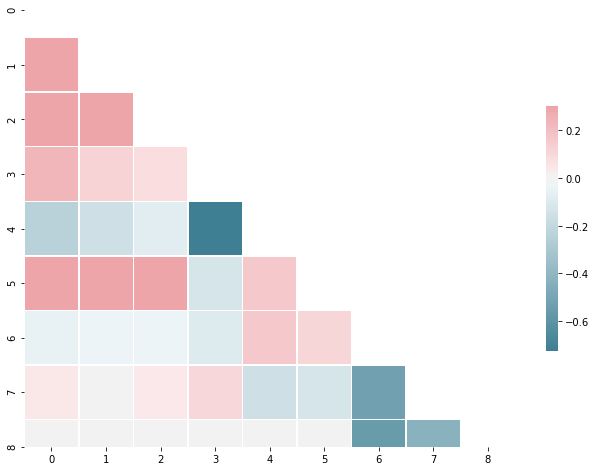

In [54]:
correlation_matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print(df.columns)

## Summary Stats for inferred numerical features 

In [55]:
df.describe()

,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas,EAP,HPL,MWS
count,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000
mean,149.057408,30.489759,16.752132,4.798393,0.028678,1.952092,0.403494,0.287808,0.308698
std,106.800189,20.995197,11.588212,0.969220,0.020427,2.092838,0.490611,0.452753,0.461968
min,21.000000,4.000000,1.000000,0.000000,0.000440,0.000000,0.000000,0.000000,0.000000
25%,81.000000,17.000000,9.000000,4.250000,0.016949,1.000000,0.000000,0.000000,0.000000
50%,128.000000,26.000000,14.000000,4.866667,0.023729,1.000000,0.000000,0.000000,0.000000
75%,191.000000,39.000000,21.000000,5.428571,0.033898,3.000000,1.000000,1.000000,1.000000
max,4663.000000,875.000000,440.000000,8.857143,0.483051,48.000000,1.000000,1.000000,1.000000


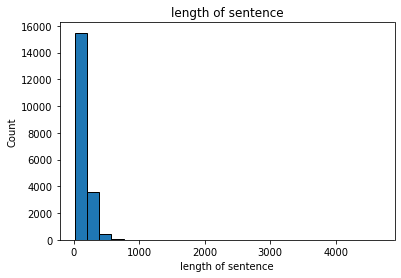

In [56]:
plt.hist(df['length'], edgecolor = 'k', bins = 25)
plt.title('length of sentence'); plt.xlabel('length of sentence'); plt.ylabel('Count');

# Split data into train, valid, test

In [57]:
from sklearn.model_selection import train_test_split

features     = ['id','text'] 

#features= [c for c in datasets["train"].columns.values if c  not in ['id','text','author']]
numeric_features= [c for c in datasets["train"].columns.values if c  not in ['id','text','author','processed']]
target = 'author'

#X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)
#X_train.head()

In [58]:
# Split the provided training data into training and validationa and test
# The kaggle evaluation test set has no labels
#
from sklearn.model_selection import train_test_split

# just select a few features for a baseline experiment
X_train= datasets["train"][features]
y_train = datasets["train"][target]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_kaggle_test= datasets["test"][features]
# y_test = datasets["application_test"]['TARGET']   #why no  TARGET?!! (hint: kaggle competition)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")
print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")
X_train.head()

X train           shape: (14145, 2)
X validation      shape: (2937, 2)
X test            shape: (2497, 2)
X X_kaggle_test   shape: (8392, 2)


,id,text
5594,id07741,The Turk plays with his left arm.
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe..."
8914,id15805,"The shutter rattled more loudly, unfastened, a..."
9358,id25515,"I was evidently approaching it, and with great..."
3891,id17107,"As she walked along, seemingly incommoded by t..."


# Baseline Model with ColumnTransform


## Transformer: 
A Transformer is an algorithm which can transform one dataset into another (usually resulting in a numpy array). 

## Estimator: 
An Estimator is an algorithm which can be fit on a dataset to produce a model. 



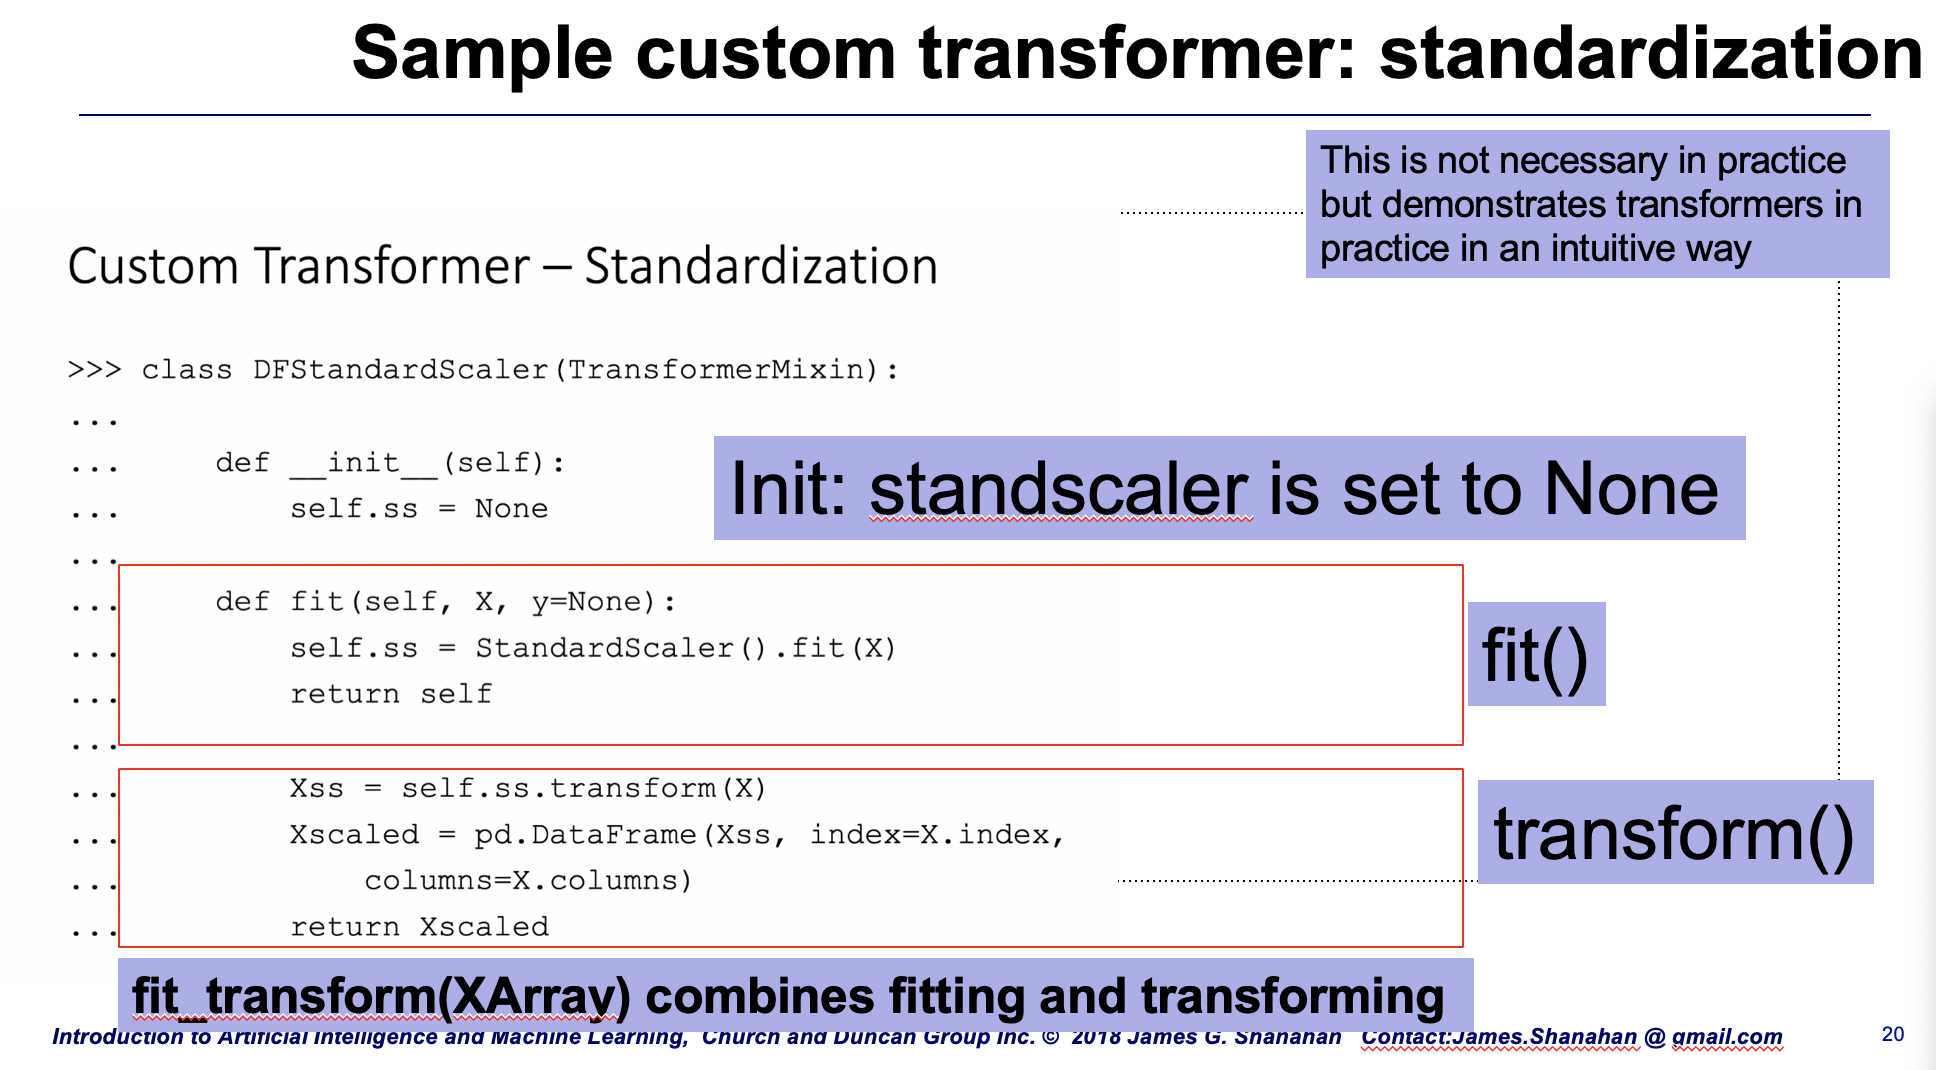

## Pipeline: 
A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.


## ColumnTransform
Many datasets contain features of different types, say text, floats, and dates, where each type of feature requires separate preprocessing or feature extraction steps. Often it is easiest to preprocess data before applying scikit-learn methods, for example using pandas. Processing your data before passing it to scikit-learn might be problematic for one of the following reasons:
Incorporating statistics from test data into the preprocessors makes cross-validation scores unreliable (known as data leakage), for example in the case of scalers or imputing missing values.
You may want to include the parameters of the preprocessors in a parameter search.
The ColumnTransformer helps performing different transformations for different columns of the data, within a Pipelinethat is safe from data leakage and that can be parametrized. ColumnTransformer works on arrays, sparse matrices, andpandas DataFrames.


## Extract numeric features from text feature

Let's convert our EDA/text preprocessing function into a transformer class so we can use as part of a pipeline to produce the following features:

* count the number of words in each row 
* the number of characters
* the number of non stop words 
* punctuation to text characters ratio 

This is old function that we will convert into a transformer class below:

In [66]:
# old code!
#
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stopWords = set(stopwords.words('english'))

# creating a function to encapsulate EDA/preprocessing
# Take a dataframe as input and return DF as output
# Add new numerical features to the dataframe (e.g., number of words in the string)
#
def textPreprocessing(df):
    #lowercase the text strings and remove punctuation
    # store in a new column
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))  #\w [a-zA-Z0-9_] \s [ \t\n\r\f\v]
    
    # numerical feature engineering
    # total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    # get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    # get the average word length
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    # get the sum(map(text.count, string.punctuation))/len(text)
    df['punctuationRatio'] = df['text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    return(df)  # return a dataframe for now

#datasets["train"] = textPreprocessing(datasets["train"])
#datasets["train"].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
np.array([2,3,4])

array([2, 3, 4])

In [68]:
X_train.head()

,id,text,processed
5594,id07741,The Turk plays with his left arm.,the turk plays with his left arm
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe...",well jupiter picked up the parchment wrappe...
8914,id15805,"The shutter rattled more loudly, unfastened, a...",the shutter rattled more loudly unfastened a...
9358,id25515,"I was evidently approaching it, and with great...",i was evidently approaching it and with great...
3891,id17107,"As she walked along, seemingly incommoded by t...",as she walked along seemingly incommoded by t...


In [69]:
# NOTE Expects a dataframe as input
# Transformer
class extractNumericFeaturesFromTextDF(BaseEstimator, TransformerMixin):
    def __init__(self, feature='text'): # no *args or **kargs
        self.feature = feature
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, df):
        #lowercase the text strings and remove punctuation
        # store in a new column
        # from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
        # construct object  array with 6 columns
        features = np.zeros((df.shape[0], 6))
 
        df['processed'] = df[self.feature].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))
        # numerical feature engineering
        # total length of sentence
        features[:,0] = df['processed'].apply(lambda x: len(x))
        # get number of words
        features[:,1] = df['processed'].apply(lambda x: len(x.split(' ')))
        features[:,2] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
        # get the average word length
        features[:,3] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
        # get the sum(map(text.count, string.punctuation))/len(text)
        features[:,4] = df['text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
        features[:,5] = df['text'].apply(lambda x: x.count(','))
        return features

### Do a local test on the text->numerics transformer

Do a local test on the transformer to see if everything is working as planned.


In [70]:
numericsFromText = extractNumericFeaturesFromTextDF(feature='text')
#pipelines will clobber your training data so do a copy (shallow copy is sufficient)
numericsFromText_attribs = numericsFromText.transform(X_train)     

numericsFromText_attribs = pd.DataFrame(numericsFromText_attribs, 
                                        columns=list(['length', 'words', 'words_not_stopword', 
                                                      'avg_word_length', 'punctuationRatio', 'commas']))
numericsFromText_attribs.head()   
    

,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas
0,33.0,8.0,5.0,3.200000,0.030303,0.0
1,84.0,21.0,12.0,3.583333,0.059524,3.0
2,87.0,15.0,10.0,5.300000,0.034483,2.0
3,56.0,11.0,6.0,5.500000,0.035714,1.0
4,127.0,24.0,17.0,5.235294,0.031496,3.0


## ColumnTransformer for heterogeneous data  
###  applies transformers to columns of an array or pandas DataFrame
```python
class sklearn.compose.ColumnTransformer(transformers, remainder=’drop’, sparse_threshold=0.3, n_jobs=None, transformer_weights=None, verbose=False)
```

Applies transformers to columns of an array or pandas DataFrame.

This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
np.random.seed(42)

# We create the preprocessing pipelines for both numeric and text data.
text_pipeline = Pipeline([
                ('selector', DataFrameSelector('text')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

text_features_basis = ['text']
numeric_transformer = Pipeline([
        ('extract_numeric_features_from_text', extractNumericFeaturesFromTextDF('text')), #DF as input --> Numpy Array
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

data_prep_pipeline = ColumnTransformer( #acc
    transformers=[
        ('num', numeric_transformer, text_features_basis),  #transformer, input features
        ('text_pipeline', text_pipeline, text_features_basis)
    ])

full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("classifier", RandomForestClassifier(random_state = 42))
    ])
# NOTE: X_train.head() #dataframe with hetrogenous columns
model = full_pipeline_with_predictor.fit(X_train, y_train)
print("model score: %.3f" % model.score(X_train, y_train))
print("model score: %.3f" % model.score(X_test, y_test))
np.round(accuracy_score(y_train, model.predict(X_train)), 3)

model score: 0.984
model score: 0.626


0.984

In [124]:
X_train.head() #dataframe

,id,text,processed
5594,id07741,The Turk plays with his left arm.,the turk plays with his left arm
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe...",well jupiter picked up the parchment wrappe...
8914,id15805,"The shutter rattled more loudly, unfastened, a...",the shutter rattled more loudly unfastened a...
9358,id25515,"I was evidently approaching it, and with great...",i was evidently approaching it and with great...
3891,id17107,"As she walked along, seemingly incommoded by t...",as she walked along seemingly incommoded by t...


In [75]:
from sklearn.metrics import accuracy_score

np.round(accuracy_score(y_train, model.predict(X_train)), 3)

0.984

## Grid search with multi-level pipelines
Grid search is all about figuring out what the best hyperparameters of the data set is. To see the list of all the possible things you could fine tune, call get_params().keys() on your pipeline.

In [76]:
list(full_pipeline_with_predictor.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preparation',
 'classifier',
 'preparation__n_jobs',
 'preparation__remainder',
 'preparation__sparse_threshold',
 'preparation__transformer_weights',
 'preparation__transformers',
 'preparation__verbose',
 'preparation__num',
 'preparation__text_pipeline',
 'preparation__num__memory',
 'preparation__num__steps',
 'preparation__num__verbose',
 'preparation__num__extract_numeric_features_from_text',
 'preparation__num__imputer',
 'preparation__num__std_scaler',
 'preparation__num__extract_numeric_features_from_text__feature',
 'preparation__num__imputer__add_indicator',
 'preparation__num__imputer__copy',
 'preparation__num__imputer__fill_value',
 'preparation__num__imputer__missing_values',
 'preparation__num__imputer__strategy',
 'preparation__num__imputer__verbose',
 'preparation__num__std_scaler__copy',
 'preparation__num__std_scaler__with_mean',
 'preparation__num__std_scaler__with_std',
 'preparation__text_pipeline__memory',
 'preparation__text_p

In [77]:
%%time
from sklearn.model_selection import GridSearchCV

hyperparameters = { 'preparation__text_pipeline__tfidf__max_df': [0.9, 0.95],
                    'preparation__text_pipeline__tfidf__ngram_range': [(1,1), (1,2)],
                    'classifier__max_depth': [50, 70],
                    'classifier__min_samples_leaf': [1,2]
                  }
 
# This might take a while
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
#    ConductGridSearch(x_train, y_train, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)# Fit and tune model
    clf = GridSearchCV(full_pipeline_with_predictor, hyperparameters, cv=3, n_jobs=-1,verbose=1)
    model = clf.fit(X_train, y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   18.2s finished


CPU times: user 3.88 s, sys: 490 ms, total: 4.37 s
Wall time: 19.6 s


In [78]:
# Best hyperparameters are: 
clf.best_params_

{'classifier__max_depth': 70,
 'classifier__min_samples_leaf': 2,
 'preparation__text_pipeline__tfidf__max_df': 0.9,
 'preparation__text_pipeline__tfidf__ngram_range': (1, 1)}

## Evaluation metrics for 3-class problem
Submissions are evaluated using multi-class logarithmic loss. Each id has one true class. For each id, you must submit a predicted probability for each author. The formula is then:


$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$

where N is the number of observations in the test set, M is the number of class labels (3 classes), log is the natural logarithm, yij is 1 if observation i belongs to class j and 0 otherwise, and pij is the predicted probability that observation i belongs to class j.  A log loss of zero is best but is rarely achieved.

The submitted probabilities for a given sentences are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with max(min(p,1−10−15),10−15).

Let's try to interpret the logloss for a random model (i.e., predict a probability of $\frac{1}{3}$ for each of the three classes for all test cases):

```python

print(f"baseline log loss is {-np.log(1/3):0.3f}")   #baseline log loss is 1.0986122886681098 
print(f"baseline class prob  {np.exp(-1.0986122886681098):0.3f}")   #baseline log loss is 1.0986122886681098 
print(f"baseline log loss is {-np.log(1):0.3f}")   #predicted probability of true class is 1, then zero loss! 

baseline log loss is 1.099
baseline class prob  0.333
baseline log loss is -0.000
```

We only look at the predicted probability of the true class. It should be 1 but it is $\frac{1}{3}$.

### Submission discussion

The logloss for the baseline submission is $0.83$. That means we are predicting a probability of 0.43 for the target class; it should be 1 or close to 1. So we have lots of room for improvement!!

```python

np.exp(-0.83) # means we are predicting a probability of 0.43 for the target class; it should be 1 or close to 1.

```

In [79]:

print(f"baseline log loss is {-np.log(1/3):0.3f}")   #baseline log loss is 1.0986122886681098 
print(f"baseline class prob  {np.exp(-1.0986122886681098):0.3f}")   #baseline log loss is 1.0986122886681098 
print(f"baseline log loss is {-np.log(1):0.3f}")   #predicted probability of true class is 1, then zero loss! 


baseline log loss is 1.099
baseline class prob  0.333
baseline log loss is -0.000


In [80]:
np.exp(-0.83) # means we are predicting a probability of 0.43 for the target class; it should be 1 or close to 1.

0.4360492863215356

In [82]:
from sklearn.metrics import log_loss
exp_name = "baseline"
try:
    expLog
except NameError:
   expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train LogLoss", 
                                   "Valid LogLoss",
                                   "Test  LogLoss"
                                  ])

expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                log_loss(y_train, model.predict_proba(X_train)),
                log_loss(y_valid, model.predict_proba(X_valid)),
                log_loss(y_test, model.predict_proba(X_test))],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train LogLoss,Valid LogLoss,Test LogLoss
0,baseline,0.6912,0.6384,0.634,0.846,0.8974,0.8977
1,baseline,0.6912,0.6384,0.634,0.846,0.8974,0.8977


## Submission File Prep

You must submit a csv file with the id, and a probability for each of the three classes. The order of the rows does not matter. The file must have a header and should look like the following:

```python 
id	EAP	HPL	MWS			
id02310	0.298695	0.281914	0.419391
id24541	0.554302	0.250418	0.195281
id00134	0.331857	0.472893	0.195250
id27757	0.534575	0.264700	0.200725
id04081	0.522426	0.233630	0.243944
etc.
```

In [83]:
#preprocessing
#submission = textPreprocessing(submission)
submit_df = model.predict_proba(textPreprocessing(datasets["test"]))
submit_df = pd.DataFrame(data=submit_df, columns = clf.best_estimator_.named_steps['classifier'].classes_)

In [ ]:
submit_df[0:10]

In [ ]:
# Submission dataframe
submit_df = pd.concat([datasets["test"][['id']], submit_df], axis=1)
submit_df.set_index('id', inplace = True)
submit_df.head()
submit_df.head()

In [ ]:
submit_df.to_csv("submission.csv",index=True)

In [ ]:
!head submission.csv

# Kaggle submission via the command line API

In [ ]:
! kaggle competitions submit -c $competition -f submission.csv -m "baseline submission"

In [ ]:
competition

## report submission

To verify your submission and get a look at your submission score, please click on this [link](https://www.kaggle.com/c/spooky-author-identification/submissions?sortBy=date&group=all&page=1)

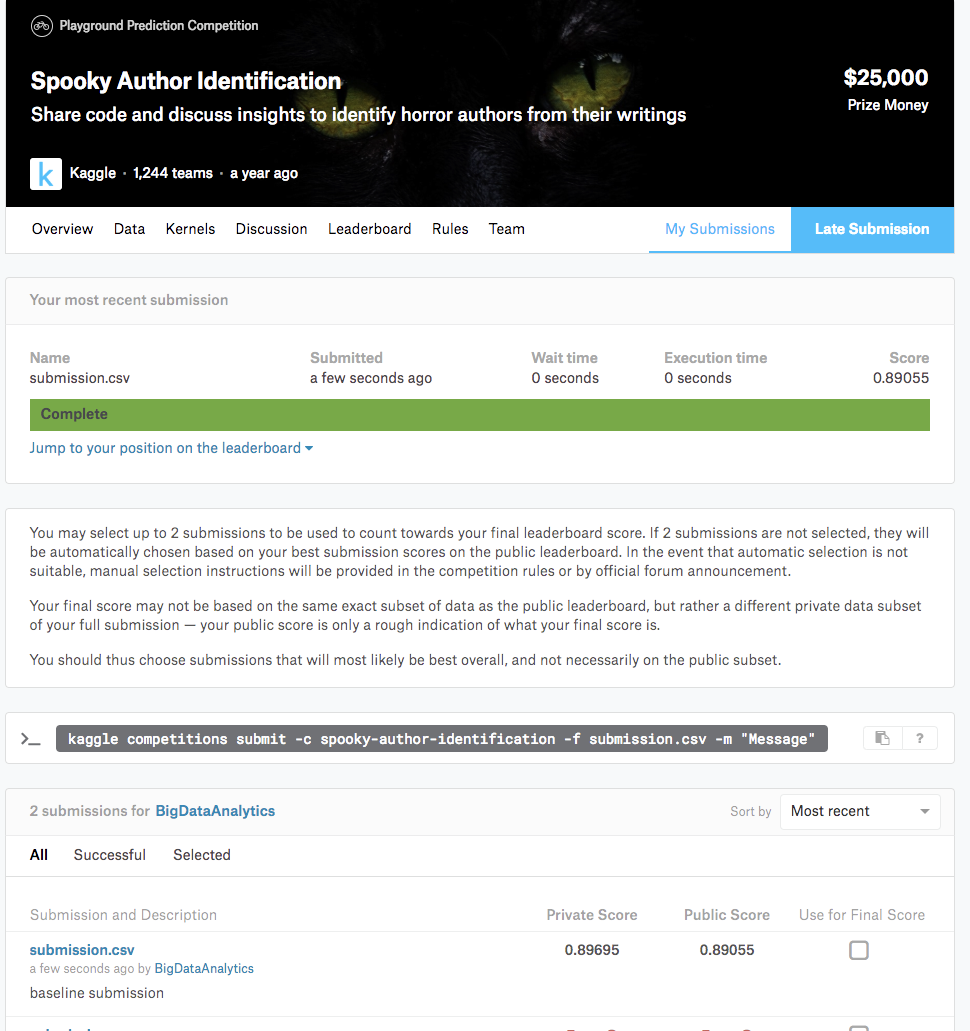

# Data preprocessing pipeline

## Split data into train, valid, test

In [84]:
from sklearn.model_selection import train_test_split

features     = ['id','text'] 

#features= [c for c in datasets["train"].columns.values if c  not in ['id','text','author']]
numeric_features= [c for c in datasets["train"].columns.values if c  not in ['id','text','author','processed']]
target = 'author'

#X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.33, random_state=42)
#X_train.head()

In [85]:
# Split the provided training data into training and validationa and test
# The kaggle evaluation test set has no labels
#
from sklearn.model_selection import train_test_split

# just select a few features for a baseline experiment
X_train= datasets["train"][features]
y_train = datasets["train"][target]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_kaggle_test= datasets["test"][features]
# y_test = datasets["application_test"]['TARGET']   #why no  TARGET?!! (hint: kaggle competition)
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")
print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")
X_train.head()

X train           shape: (14145, 2)
X validation      shape: (2937, 2)
X test            shape: (2497, 2)
X X_kaggle_test   shape: (8392, 2)


,id,text
5594,id07741,The Turk plays with his left arm.
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe..."
8914,id15805,"The shutter rattled more loudly, unfastened, a..."
9358,id25515,"I was evidently approaching it, and with great..."
3891,id17107,"As she walked along, seemingly incommoded by t..."


###  DataFrameSelector as column-based feature selector

The following is a homemade DataFrameSelector Class that plugs a gap in SKlearn's transformation logic; Scikit-Learn transformers/pipelines only accept Numpy arrays and doesn't handle DataFrames yet. The DataFrameSelector Class at an abstact level accepts as input a DataFrame object, selects a subset of the dataframe (i.e., select the desired attributes via a column-based selection), and returns a Numpy Array as  output.  

With this DataFrameSelector Class, you can easily write a pipeline that will take a Pandas DataFrame as input. Note: it the dataframe can only consist of numerical values. A typical usecase is where the pipeline would just start with a DataFrameSelector to pick only the numerical attributes (i.e., not the categorical), followed by  other preprocessing such as standardization. And you can just as easily write another pipeline for the categorical
attributes as well by simply selecting the categorical attributes using a DataFrameSelector and then applying various OHE transformations.

## Extract numeric features from text feature

Let's convert our EDA/text preprocessing function into a transformer class so we can use as part of a pipeline to produce the following features:

* count the number of words in each row 
* the number of characters
* the number of non stop words 
* punctuation to text characters ratio 

This is old function that we will convert into a transformer class below:

In [86]:
# old code!
#
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stopWords = set(stopwords.words('english'))

# creating a function to encapsulate EDA/preprocessing
# Take a dataframe as input and return DF as output
# Add new numerical features to the dataframe (e.g., number of words in the string)
#
def textPreprocessing(df):
    #lowercase the text strings and remove punctuation
    # store in a new column
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))  #\w [a-zA-Z0-9_] \s [ \t\n\r\f\v]
    
    # numerical feature engineering
    # total length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    # get number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    # get the average word length
    df['avg_word_length'] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    # get the sum(map(text.count, string.punctuation))/len(text)
    df['punctuationRatio'] = df['text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
    df['commas'] = df['text'].apply(lambda x: x.count(','))

    return(df)  # return a dataframe for now

#datasets["train"] = textPreprocessing(datasets["train"])
#datasets["train"].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
np.array([2,3,4])

array([2, 3, 4])

In [88]:
X_train.head()

,id,text
5594,id07741,The Turk plays with his left arm.
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe..."
8914,id15805,"The shutter rattled more loudly, unfastened, a..."
9358,id25515,"I was evidently approaching it, and with great..."
3891,id17107,"As she walked along, seemingly incommoded by t..."


In [89]:
# NOTE Expects a dataframe as input

class extractNumericFeaturesFromTextDF(BaseEstimator, TransformerMixin):
    def __init__(self, feature='text'): # no *args or **kargs
        self.feature = feature
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, df): 
        #lowercase the text strings and remove punctuation
        # store in a new column
        # from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
        # construct object  array with 6 columns
        features = np.zeros((df.shape[0], 6))  
 
        df['processed'] = df[self.feature].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))
        # numerical feature engineering
        # total length of sentence
        features[:,0] = df['processed'].apply(lambda x: len(x))
        # get number of words
        features[:,1] = df['processed'].apply(lambda x: len(x.split(' ')))
        features[:,2] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
        # get the average word length
        features[:,3] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
        # get the sum(map(text.count, string.punctuation))/len(text)
        features[:,4] = df['text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
        features[:,5] = df['text'].apply(lambda x: x.count(','))
        return features

### Do a local test on the text->numerics transformer

Do a local test on the transformer to see if everything is working as planned.


In [90]:
numericsFromText = extractNumericFeaturesFromTextDF(feature='text')
#pipelines will clobber your training data so do a copy (shallow copy is sufficient)
# X_train is a dataframe
numericsFromText_attribs = numericsFromText.transform(X_train)     

numericsFromText_attribs = pd.DataFrame(numericsFromText_attribs, 
                                        columns=list(['length', 'words', 'words_not_stopword', 
                                                      'avg_word_length', 'punctuationRatio', 'commas']))
numericsFromText_attribs.head()   
    

,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas
0,33.0,8.0,5.0,3.200000,0.030303,0.0
1,84.0,21.0,12.0,3.583333,0.059524,3.0
2,87.0,15.0,10.0,5.300000,0.034483,2.0
3,56.0,11.0,6.0,5.500000,0.035714,1.0
4,127.0,24.0,17.0,5.235294,0.031496,3.0


### Incorporate into pipeline:  text->numerics transformer into pipeline
Incorporate the  text->numerics transformer into a pipeline and test run!

Remember to call `fit_transform` method to transform the data. Otherwise, no Numpy array will be output.

In [91]:
X_train.head()


,id,text,processed
5594,id07741,The Turk plays with his left arm.,the turk plays with his left arm
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe...",well jupiter picked up the parchment wrappe...
8914,id15805,"The shutter rattled more loudly, unfastened, a...",the shutter rattled more loudly unfastened a...
9358,id25515,"I was evidently approaching it, and with great...",i was evidently approaching it and with great...
3891,id17107,"As she walked along, seemingly incommoded by t...",as she walked along seemingly incommoded by t...


In [92]:
%%time 
# Identify the numeric features we wish to consider. 
num_attribs = ['length','words','words_not_stopword', 'avg_word_length','commas']

num_pipeline = Pipeline([
        ('extract_numeric_features_from_text', extractNumericFeaturesFromTextDF('text')), #DF as input --> Numpy Array
        #('selector', DataFrameSelector(num_attribs)), #not  necessary here as step #1 outputs a Numpy Array
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])
numericsFromText_attribs = num_pipeline.fit(X_train, y_train)
print(f"numericsFromText_attribs after fit():\n {numericsFromText_attribs}\n\n")

numericsFromText_attribs = num_pipeline.fit_transform(X_train, y_train)
print(f"numericsFromText_attribs after fit_transform(): \n{numericsFromText_attribs}")


numericsFromText_attribs after fit():
 Pipeline(memory=None,
         steps=[('extract_numeric_features_from_text',
                 extractNumericFeaturesFromTextDF(feature='text')),
                ('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)


numericsFromText_attribs after fit_transform(): 
[[-1.05293296 -1.03965891 -0.99080903 -1.6473945   0.0812137  -0.92452567]
 [-0.59087709 -0.43892651 -0.40073952 -1.25357122  1.52790874  0.49837607]
 [-0.56369733 -0.71618762 -0.56933081  0.51007218  0.28814836  0.02407549]
 ...
 [-0.01104228  0.06938551 -0.31644388 -0.0352216  -0.41549942  0.02407549]
 [ 0.73187108  0.57769754  0.86369513  0.84872215 -0.98854856 -0.45022509]
 [ 0.43289375  0.34664662  0.6951

###  Put transformer output in a dataframe
Put things in a dataframe so we can view the progress in style!


In [97]:
# put things in a dataframe so we can view the progress in style!
numericsFromText_attribs = pd.DataFrame(numericsFromText_attribs, 
                                        columns=list(['length', 'words', 'words_not_stopword', 
                                                      'avg_word_length', 'punctuationRatio', 'commas']))
numericsFromText_attribs.head()   

,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas
0,-1.052933,-1.039659,-0.990809,-1.647395,0.081214,-0.924526
1,-0.590877,-0.438927,-0.400740,-1.253571,1.527909,0.498376
2,-0.563697,-0.716188,-0.569331,0.510072,0.288148,0.024075
3,-0.844555,-0.901028,-0.906513,0.715545,0.349120,-0.450225
4,-0.201301,-0.300296,0.020739,0.443596,0.140280,0.498376


#### Check if the numeric variables are standardized
Mean =0.0; std =1.0: Yes!

In [98]:
numericsFromText_attribs.describe()

,length,words,words_not_stopword,avg_word_length,punctuationRatio,commas
count,1.414500e+04,1.414500e+04,1.414500e+04,1.414500e+04,1.414500e+04,1.414500e+04
mean,-4.671649e-17,3.064200e-17,-3.666993e-17,9.744909e-15,1.331119e-14,7.534918e-18
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-1.161652e+00,-1.224500e+00,-1.243696e+00,-4.934963e+00,-1.397300e+00,-9.245257e-01
25%,-6.180568e-01,-6.237673e-01,-6.536265e-01,-5.686612e-01,-5.846393e-01,-4.502251e-01
50%,-1.922407e-01,-2.078756e-01,-2.321482e-01,7.344202e-02,-2.495559e-01,-4.502251e-01
75%,3.785342e-01,3.928568e-01,3.579213e-01,6.584694e-01,2.592126e-01,4.983761e-01
max,4.089449e+01,3.902457e+01,3.567780e+01,4.164557e+00,1.995988e+01,2.184190e+01


### TF_IDF Subpipeline
The following usecase selects a text column and then applies a TFIDF vectorizer as the next step in the data prep pipeline. 

In [99]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# return a Numpy Array
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values  #return a Numpy Array to observe the pipeline protocol

Create a sub-pipeline (`sub` because it will form a first step in a bigger pipeline later) consists of "selecting" and then [`TDIDF-ing`](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) the `processed text` column.

To execute, use it just like any other transformer. You can call `text.fit()` to fit to training data, `text.transform()` to apply it to training data, or `text.fit_transform()` to do both.

Since it's text that is transformed to a one-hot-encoded-like doc-term matrix, this subpipeline will return a sparse matrix.  

In [100]:
# NOTE Expects a dataframe as input
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#sphx-glr-auto-examples-compose-plot-column-transformer-py
#TODO
class extractTokensFromTextDF_TODO(BaseEstimator, TransformerMixin):
    def __init__(self, feature='text'): # no *args or **kargs
        self.feature = feature
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, df):
        #lowercase the text strings and remove punctuation
        # store in a new column
        # from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
        # construct object  array with 6 columns
        features = np.empty(shape=(df.shape[0], 1), dtype=object)
 
        df['processed'] = df[self.feature].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))
        # numerical feature engineering
        # total length of sentence
        features[:,0] = df['processed'].apply(lambda x: len(x))
        # get number of words
        features[:,1] = df['processed'].apply(lambda x: len(x.split(' ')))
        features[:,2] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
        # get the average word length
        features[:,3] = df['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
        # get the sum(map(text.count, string.punctuation))/len(text)
        features[:,4] = df['text'].apply(lambda x: sum(map(x.count, string.punctuation))/len(x))
        features[:,5] = df['text'].apply(lambda x: x.count(','))
        return features

In [101]:
X_train

,id,text,processed
5594,id07741,The Turk plays with his left arm.,the turk plays with his left arm
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe...",well jupiter picked up the parchment wrappe...
8914,id15805,"The shutter rattled more loudly, unfastened, a...",the shutter rattled more loudly unfastened a...
9358,id25515,"I was evidently approaching it, and with great...",i was evidently approaching it and with great...
3891,id17107,"As she walked along, seemingly incommoded by t...",as she walked along seemingly incommoded by t...
...,...,...,...
11085,id01721,"Near the spot where we found it, I observed th...",near the spot where we found it i observed th...
11159,id15324,"They gathered round him, counted their numbers...",they gathered round him counted their numbers...
3822,id00719,Not that she was ever serious upon this point ...,not that she was ever serious upon this point ...
15112,id03220,I refer to a sort of cloudy whitish pattern on...,i refer to a sort of cloudy whitish pattern on...


In [102]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

text_pipeline = Pipeline([
                ('selector', DataFrameSelector('text')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

text_attribs = text_pipeline.fit(X_train, y_train)
print(f"text_attribs after fit():\n {text_attribs}\n\n")


#text_attribs = text_pipeline.fit_transform(X_train, y_train)
#print(f"text_attribs after fit_transform(): \n{text_attribs}")
text_attribs

text_attribs after fit():
 Pipeline(memory=None,
         steps=[('selector', DataFrameSelector(attribute_names='text')),
                ('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None))],
         verbose=False)




Pipeline(memory=None,
         steps=[('selector', DataFrameSelector(attribute_names='text')),
                ('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None))],
         verbose=False)

In [103]:
X_train[0:5]

,id,text,processed
5594,id07741,The Turk plays with his left arm.,the turk plays with his left arm
10682,id06275,"""Well, Jupiter picked up the parchment, wrappe...",well jupiter picked up the parchment wrappe...
8914,id15805,"The shutter rattled more loudly, unfastened, a...",the shutter rattled more loudly unfastened a...
9358,id25515,"I was evidently approaching it, and with great...",i was evidently approaching it and with great...
3891,id17107,"As she walked along, seemingly incommoded by t...",as she walked along seemingly incommoded by t...


### Do a local test on the text->numerics transformer
Since our data is heterogeneous, we might want to do something else on numeric data, so let's build a mini pipeline for that too.


### Feature Unions example (use the same input data and process in parallel)
FeatureUnion combines several transformer objects into a new transformer that combines their output. A FeatureUnion takes a list of transformer objects. During fitting, each of these is fit to the data independently. For transforming data, the transformers are applied in parallel, and the sample vectors they output are concatenated end-to-end into larger vectors.


In [123]:
from sklearn.datasets import load_iris

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import datasets

iris = load_iris()

X, y = iris["data"], iris["target"]

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit_transform(X, y)
X_features.shape  # 2 PComponent features and 1 raw feature is selected

(150, 3)

In [104]:
%%time 
# Identify the numeric features we wish to consider. 
#num_attribs = ['length','words','words_not_stopword', 'avg_word_length','commas']

num_pipeline = Pipeline([
        ('extract_numeric_features_from_text', extractNumericFeaturesFromTextDF('text')), #DF as input --> Numpy Array
        #('selector', DataFrameSelector(num_attribs)), #not  necessary here as step #1 outputs a Numpy Array
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])
# Identify the categorical features we wish to consider.
#cat_attribs = ['CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
#               'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']

#cat_pipeline = Pipeline([
#        ('selector', DataFrameSelector(cat_attribs)),
#        ('imputer', SimpleImputer(strategy='most_frequent')),
#        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
#    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
#        ("cat_pipeline", cat_pipeline),
        ("text_pipeline", text_pipeline)
    ])
              
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("classifier", RandomForestClassifier(random_state = 42))
    ])
model = full_pipeline_with_predictor.fit(X_train, y_train)



CPU times: user 4.19 s, sys: 160 ms, total: 4.35 s
Wall time: 2.75 s


In [105]:
%%time 
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("classifier", RandomForestClassifier(random_state = 42))
    ])
model = full_pipeline_with_predictor.fit(X_train, y_train)


CPU times: user 4.68 s, sys: 60 ms, total: 4.74 s
Wall time: 3.07 s


## Study the transformed data via a dataframe

Pipelines basic data unit is a NumPy Array.  NumPy Arrays do **NOT** have column names.  Structured arrays (see below for more information) provide this capability but Pipeline does not support such a structure currently. The goal of this section is have a quick look at the dataset that was generated with the data gen pipeline presented so far. To do this we create a dataframe where the columns are labeled using the corresponding feature names via the following steps:

* Collext the attribute names into a list
* Create a transient data frame so the data can be presented  neatly

### Structured arrays detour
(Aside:  Structured arrays are ndarrays whose datatype is a composition of simpler datatypes organized as a sequence of named fields. For example,

```python
>>> x = np.array([('Rex', 9, 81.0), ('Fido', 3, 27.0)],
...              dtype=[('name', 'U10'), ('age', 'i4'), ('weight', 'f4')])
>>> x
array([('Rex', 9, 81.0), ('Fido', 3, 27.0)],
      dtype=[('name', 'S10'), ('age', '<i4'), ('weight', '<f4')])

```

Here x is a one-dimensional array of length two whose datatype is a structure with three fields: 1. A string of length 10 or less named ‘name’, 2. a 32-bit integer named ‘age’, and 3. a 32-bit float named ‘weight’.

```python
>>> x['age']
array([9, 3], dtype=int32)
>>> x['age'] = 5
>>> x
array([('Rex', 5, 81.0), ('Fido', 5, 27.0)],
      dtype=[('name', 'S10'), ('age', '<i4'), ('weight', '<f4')])
```

For more information on Structure arrays see [here](https://docs.scipy.org/doc/numpy/user/basics.rec.html)



In [ ]:
'''
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
pd.DataFrame(data=housing_prepared, columns=attributes).head()
'''

In [ ]:
list(X_train.columns)